# Classification - Adversarial

An attempt to replicate the results of Slack et al. with the SPAMBASE dataset. 

Main differences will be: 
- An actual MLP model will be used for the 'facade' model (this may make the effect less strong). 
- SHAP only (for now)

Parts of this code are reused from the work by Slack et al., refer to https://arxiv.org/abs/1911.02508 for the paper, and https://github.com/dylan-slack/Fooling-LIME-SHAP for the code repository.

In [1]:
# Import third party modules
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
import random
import pickle
import copy

# For visualisations
shap.initjs()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
from temp_utils import *
params = Params("temp_experiment_params.json")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from copy import deepcopy
import sys

In [4]:
from exrt.sensitivity import calculate_sensitivity
from exrt.infidelity import calculate_infidelity
from exrt.metadata import get_feature_names, get_feature_names_of_type, append_indices, append_baselines


In [5]:
# Import custom modules
from helpers.feature_columns import get_normalization_parameters, create_numeric_columns, create_categorical_columns
from helpers.dataset_converter import convert_df_dataset, convert_dataframe_numpy, convert_numpy_tensor
from helpers.model_creation import create_fit_model

from data.classification_spam.spambase_helpers import get_names, get_metadata

In [6]:
# Import helper functions reused from Slack et al.
from helpers.model_adversarial import one_hot_encode, Params, Adversarial_Model, Adversarial_Kernel_SHAP_Model

In [7]:
# Import data from csv
csv_file = 'data/classification_spam/spambase.data'
feature_names = names=get_names()
feature_names.insert(0, 'explanation_feature')
dataframe = pd.read_csv(csv_file, index_col=False, sep=',', names=get_names())

In [8]:
# Add a column which we will attempt to fool SHAP into thinking is salient
dataframe.insert(loc=58, column='explanation_feature', value=np.random.choice([0,1],size=dataframe.shape[0]))

In [9]:
dataframe.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_open_bracket,char_freq_square_bracket,char_freq_exclamation,char_freq_dollar,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class,explanation_feature
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1,0
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1,0
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1,0


In [10]:
metadata = get_metadata()

metadata.pop(57) # Remove class column

metadata.append({ # Append explanation feature column
    'name': 'explanation_feature',
    'type': 'numerical',
    'used': True
})

# Append indexes to metadata
metadata = append_indices(metadata)

# We set all baselines to zero as metadata has been normalised
for feat in metadata:
    feat['baseline'] = 0
    
y = dataframe.pop('class').to_numpy()
X = dataframe.to_numpy()

In [11]:
# Get indices of our main columns
capital_index = feature_names.index('capital_run_length_longest')
unrelated_index = feature_names.index('explanation_feature')

In [12]:
class biased_model_f:
    # We don't have a feature with potential for 'bias' in this dataset, so we use capital_run_length_longest
    def predict(self,X):
        if X.ndim == 1:
            X = np.array([X])
        # Work out mean of capital_index column
        mean_val = dataframe['capital_run_length_longest'].median()
        return np.array([0 if x[capital_index] > 0 else 1 for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

class innocuous_model_psi:
    # Decision rule: classify according to randomly drawn column 'unrelated column'
    def predict(self,X):
        if X.ndim == 1:
            X = np.array([X])
        return np.array([params.negative_outcome if x[unrelated_index] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

In [13]:
# Split the data and normalize
xtrain,xtest,ytrain,ytest = train_test_split(X,y)
xtest_not_normalized = deepcopy(xtest)
ss = StandardScaler().fit(xtrain)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)

In [14]:
# Train a simple MLP model using SciKit learn, this is a 'genuine' model that attempts to minimise loss in the usual way
# (as opposed to biased_model_f and innocuous_model_psi, which are both trivial and just look at a single feature value)
mlp_model = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(20, 60, 10)).fit(xtrain, ytrain)

In [15]:
# Train the adversarial model
adv_shap = Adversarial_Kernel_SHAP_Model(biased_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=feature_names)

# Train the adversarialMLP model
adv_mlp_shap = Adversarial_Kernel_SHAP_Model(biased_model_f(), mlp_model).\
            train(xtrain, ytrain, feature_names=feature_names)

In [16]:
# Check all our various predictors can give us values

to_test = np.array([xtest[30]])
innocuous_model_psi().predict(to_test)
mlp_model.predict(to_test)
adv_shap.predict(to_test)
adv_mlp_shap.predict(to_test)

array([1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.91333333  0.        ]]


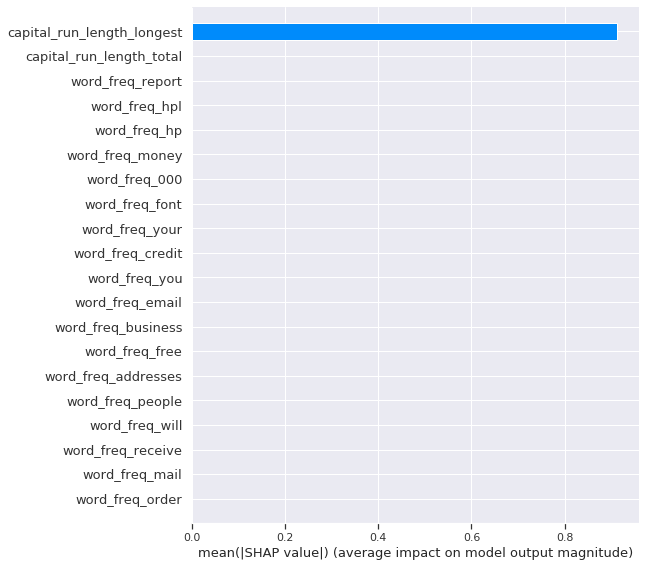

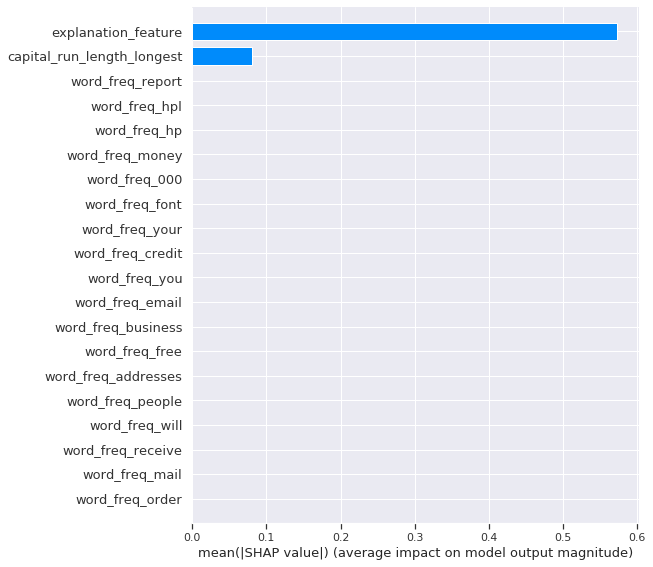

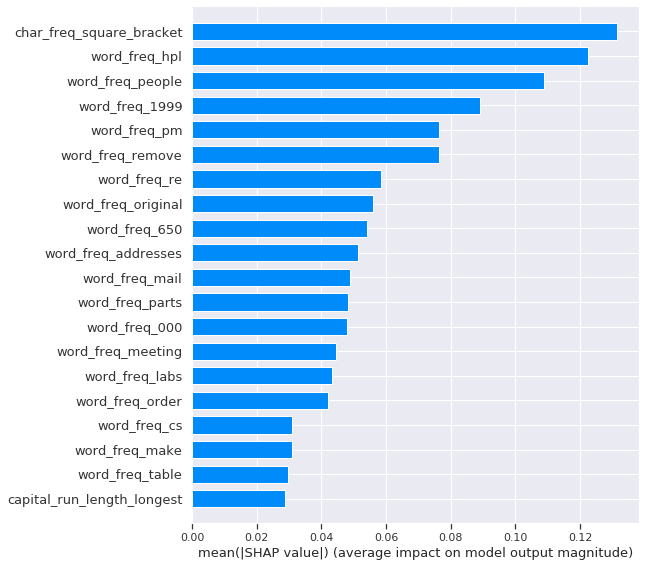

Fidelity: 1.0
Fidelity: 1.0


In [17]:
# Set the background distribution for the shap explainer using kmeans
background_distribution = shap.kmeans(xtrain,10)

# Let's use the shap kernel explainer and grab a point to explain
to_examine = np.random.choice(xtest.shape[0])

# Explain the biased model
biased_kernel_explainer = shap.KernelExplainer(biased_model_f().predict, background_distribution)
biased_shap_values = biased_kernel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Explain the adversarial model
adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Explain the adversarialMLP model
adv_mlp_kerenel_explainer = shap.KernelExplainer(adv_mlp_shap.predict, background_distribution)
adv_mlp_shap_values = adv_mlp_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Plot npit using SHAP's plotting features.
shap.summary_plot(np.array(biased_shap_values), feature_names=feature_names, plot_type="bar")
shap.summary_plot(adv_shap_values, feature_names=feature_names, plot_type="bar")
shap.summary_plot(adv_mlp_shap_values, feature_names=feature_names, plot_type="bar")

# Note - fidelity here completely different to primary use in this work
print ("Fidelity: {0:3.2}".format(adv_shap.fidelity(xtest[to_examine:to_examine+1])))
print ("Fidelity: {0:3.2}".format(adv_mlp_shap.fidelity(xtest[to_examine:to_examine+1])))

In [18]:
adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1][0])
adv_shap_values

array([-0.5765263 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.07738674,  0.        ])

In [19]:
sensitivity = calculate_sensitivity(adv_kerenel_explainer.shap_values, adv_shap_values, xtest[to_examine:to_examine+1][0], metadata, skip_zero_saliency_features=True, proportion_features_perturbed=0.05, input_normalised=True)
sensitivity

0.1094413835385325

In [20]:
infidelity = calculate_infidelity(adv_shap_values, adv_shap, np.array(xtest[to_examine:to_examine+1][0]), metadata, input_normalised=True)
infidelity

array([0.95911447])

In [53]:
# Loop through first 10 test instances
# Loop through three different models
# Calculate fidelity, sensitivity

class ModelForMLP():
    def __init__(self, model):
        self.model = model
    def predict(self, instance):
        return self.model.predict([instance])[0]

def compare_models():
    
    comparison = pd.DataFrame(columns=['model', 'prediction', 'instance_index', 'explanation', 'sensitivity', 'infidelity'])
    
    biased_model = biased_model_f()
    innocuous_model = innocuous_model_psi()
    mlp_model_infidelity = ModelForMLP(mlp_model)
    for idx in range(10):
        print(f'Starting index: {idx}')
        instance = np.array([xtest[idx]])

        # Biased model f
        biased_prediction = biased_model.predict(instance)[0]
        biased_kernel_explainer = shap.KernelExplainer(biased_model.predict, background_distribution)
        biased_shap_values = biased_kernel_explainer.shap_values(instance, silent=True)
        biased_sensitivity = calculate_sensitivity(biased_kernel_explainer.shap_values, biased_shap_values[0], instance[0], metadata, skip_zero_saliency_features=True, proportion_features_perturbed=0.05, input_normalised=True)
        biased_infidelity = calculate_infidelity(biased_shap_values[0], biased_model, instance[0], metadata, input_normalised=True)
        comparison = comparison.append({
            'model': 'biased',
            'prediction': biased_prediction,
            'instance_index': idx,
            'explanation': biased_shap_values,
            'sensitivity': biased_sensitivity,
            'infidelity': biased_infidelity
        }, ignore_index=True)
        
        # Innocuous model (psi)
        innocuous_prediction = innocuous_model.predict(instance)[0]
        innocuous_kernel_explainer = shap.KernelExplainer(biased_model.predict, background_distribution)
        innocuous_shap_values = innocuous_kernel_explainer.shap_values(instance, silent=True)
        innocuous_sensitivity = calculate_sensitivity(innocuous_kernel_explainer.shap_values, innocuous_shap_values[0], instance[0], metadata, skip_zero_saliency_features=True, proportion_features_perturbed=0.05, input_normalised=True)
        innocuous_infidelity = calculate_infidelity(innocuous_shap_values[0], innocuous_model, instance[0], metadata, input_normalised=True)
        comparison = comparison.append({
            'model': 'innocuous',
            'prediction': innocuous_prediction,
            'instance_index': idx,
            'explanation': innocuous_shap_values,
            'sensitivity': innocuous_sensitivity,
            'infidelity': innocuous_infidelity
        }, ignore_index=True)
        
        # MLP model
        mlp_prediction = mlp_model.predict(instance)[0]
        mlp_kernel_explainer = shap.KernelExplainer(mlp_model.predict, background_distribution)
        mlp_shap_values = mlp_kernel_explainer.shap_values(instance, silent=True)
        mlp_sensitivity = calculate_sensitivity(mlp_kernel_explainer.shap_values, mlp_shap_values[0], instance[0], metadata, skip_zero_saliency_features=True, proportion_features_perturbed=0.05, input_normalised=True)
        mlp_infidelity = calculate_infidelity(mlp_shap_values[0], mlp_model_infidelity, instance[0], metadata, input_normalised=True)
        comparison = comparison.append({
            'model': 'mlp',
            'prediction': mlp_prediction,
            'instance_index': idx,
            'explanation': mlp_shap_values,
            'sensitivity': mlp_sensitivity,
            'infidelity': mlp_infidelity
        }, ignore_index=True)

        # Adversarial model - simple
        adv_simple_prediction = adv_shap.predict(instance)[0]
        adv_simple_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
        adv_simple_shap_values = adv_simple_explainer.shap_values(instance, silent=True)
        adv_simple_sensitivity = calculate_sensitivity(adv_simple_explainer.shap_values, adv_simple_shap_values[0], instance[0], metadata, skip_zero_saliency_features=True, proportion_features_perturbed=0.05, input_normalised=True)
        adv_simple_infidelity = calculate_infidelity(adv_simple_shap_values[0], adv_shap, instance[0], metadata, input_normalised=True)
        comparison = comparison.append({
            'model': 'adversarial_simple',
            'prediction': adv_simple_prediction,
            'instance_index': idx,
            'explanation': adv_simple_shap_values,
            'sensitivity': adv_simple_sensitivity,
            'infidelity': adv_simple_infidelity
        }, ignore_index=True)

        # Adversarial model - MLP
        adv_mlp_prediction = adv_mlp_shap.predict(instance)[0]
        adv_mlp_explainer = shap.KernelExplainer(adv_mlp_shap.predict, background_distribution)
        adv_mlp_shap_values = adv_mlp_explainer.shap_values(instance, silent=True)
        adv_mlp_sensitivity = calculate_sensitivity(adv_mlp_explainer.shap_values, adv_mlp_shap_values[0], instance[0], metadata, skip_zero_saliency_features=True, proportion_features_perturbed=0.05, input_normalised=True)
        adv_mlp_infidelity = calculate_infidelity(adv_mlp_shap_values[0], adv_mlp_shap, instance[0], metadata, input_normalised=True)
        comparison = comparison.append({
            'model': 'adversarial_mlp',
            'prediction': adv_mlp_prediction,
            'instance_index': idx,
            'explanation': adv_mlp_shap_values,
            'sensitivity': adv_mlp_sensitivity,
            'infidelity': adv_mlp_infidelity
        }, ignore_index=True)
        
    return comparison

In [54]:
# Load the picked result, or if doesn't exist, calculate new results
try:
    comparison = pickle.load(open("pickles/classification_adversarial/comparison.p", "rb"))
except (OSError, IOError) as e:
    comparison = compare_models()
    pickle.dump(comparison, open("pickles/classification_adversarial/comparison.p", "wb" ))

Starting index: 0
Starting index: 1
Starting index: 2
Starting index: 3
Starting index: 4
Starting index: 5
Starting index: 6
Starting index: 7
Starting index: 8
Starting index: 9


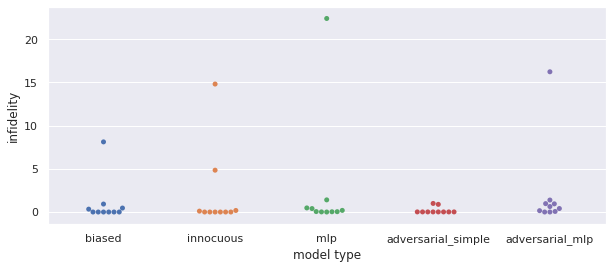

In [63]:
plt.figure(figsize=(10,4))
rect = 0,0,1,1 # create an rectangle for the new axis
ax = sns.swarmplot(x='model', y='infidelity', data=comparison)
ax.set(xlabel='model type', ylabel='infidelity')
plt.savefig('images/adversarial_infidelity.png', dpi=100)

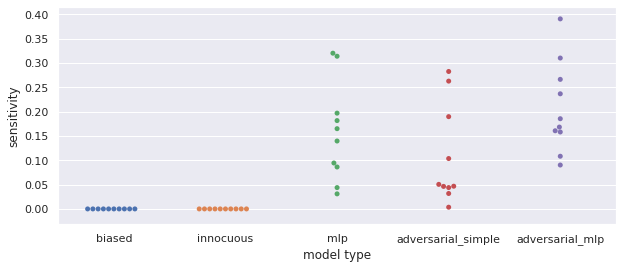

In [64]:
plt.figure(figsize=(10,4))
ax = sns.swarmplot(x='model', y='sensitivity', data=comparison)
ax.set(xlabel='model type', ylabel='sensitivity')
plt.savefig('images/adversarial_sensitivity.png', dpi=100)

In [67]:
# Calculate average values for mlp and adversarial_mlp sensitivity
means = comparison.groupby('model').mean()
means

,sensitivity
model,
adversarial_mlp,0.207623
adversarial_simple,0.106188
biased,0.000000
innocuous,0.000000
mlp,0.157353
